This notebook creates and then trains naive templates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, copy
from scipy.interpolate import interp1d

from modules import get_bandpass_dict, get_eff_wavelen, Sed, \
                    create_training_sets, train_templates, spectral_lines

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the filters

In [3]:
bandpass_dict = get_bandpass_dict()

Load the galaxy redshift catalog

In [4]:
with open('data/training_catalog.pkl', 'rb') as input:
    galaxies = pickle.load(input)

Create the naive templates

In [5]:
def log_norm(x,mode,sigma):
    mu = np.log(mode) + sigma**2
    f1 = lambda x: 1/x*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))
    return f1(x)/f1(5000)

N = 16
n = 6
modes  = np.concatenate((np.linspace(5500,4600,n,endpoint=False),np.linspace(4600,1000,N-n)))
sigmas = np.concatenate((np.linspace(0.35,0.56,n,endpoint=False),np.linspace(0.56, 0.9,N-n)))

# save the templates as Seds
x = np.arange(10,15000,100,dtype=float)
naive_templates = dict()
for i in range(N):
    template = Sed()
    template.wavelen = x
    template.flambda = log_norm(x,modes[i],sigmas[i])
    naive_templates["N16-"+str(i+1)] = template
    
del N,n,modes,sigmas,x,i,template

Create training sets and plot them

In [6]:
%%time
training_sets = create_training_sets(galaxies,naive_templates,bandpass_dict)

CPU times: user 9.55 s, sys: 773 ms, total: 10.3 s
Wall time: 1min 30s


In [7]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('galaxies', 657120),
 ('Sed', 1064),
 ('interp1d', 1064),
 ('bandpass_dict', 656),
 ('naive_templates', 656),
 ('training_sets', 656),
 ('input', 184),
 ('create_training_sets', 144),
 ('get_bandpass_dict', 144),
 ('get_eff_wavelen', 144),
 ('log_norm', 144),
 ('spectral_lines', 144),
 ('train_templates', 144),
 ('np', 88),
 ('plt', 88),
 ('onecol', 24),
 ('twocol', 24)]

Number of fluxes in each training set:
[50890, 34294, 28648, 26014, 25353, 25551, 32785, 37231, 31027, 20114, 10632, 9209, 12865, 17174, 21727, 28214]


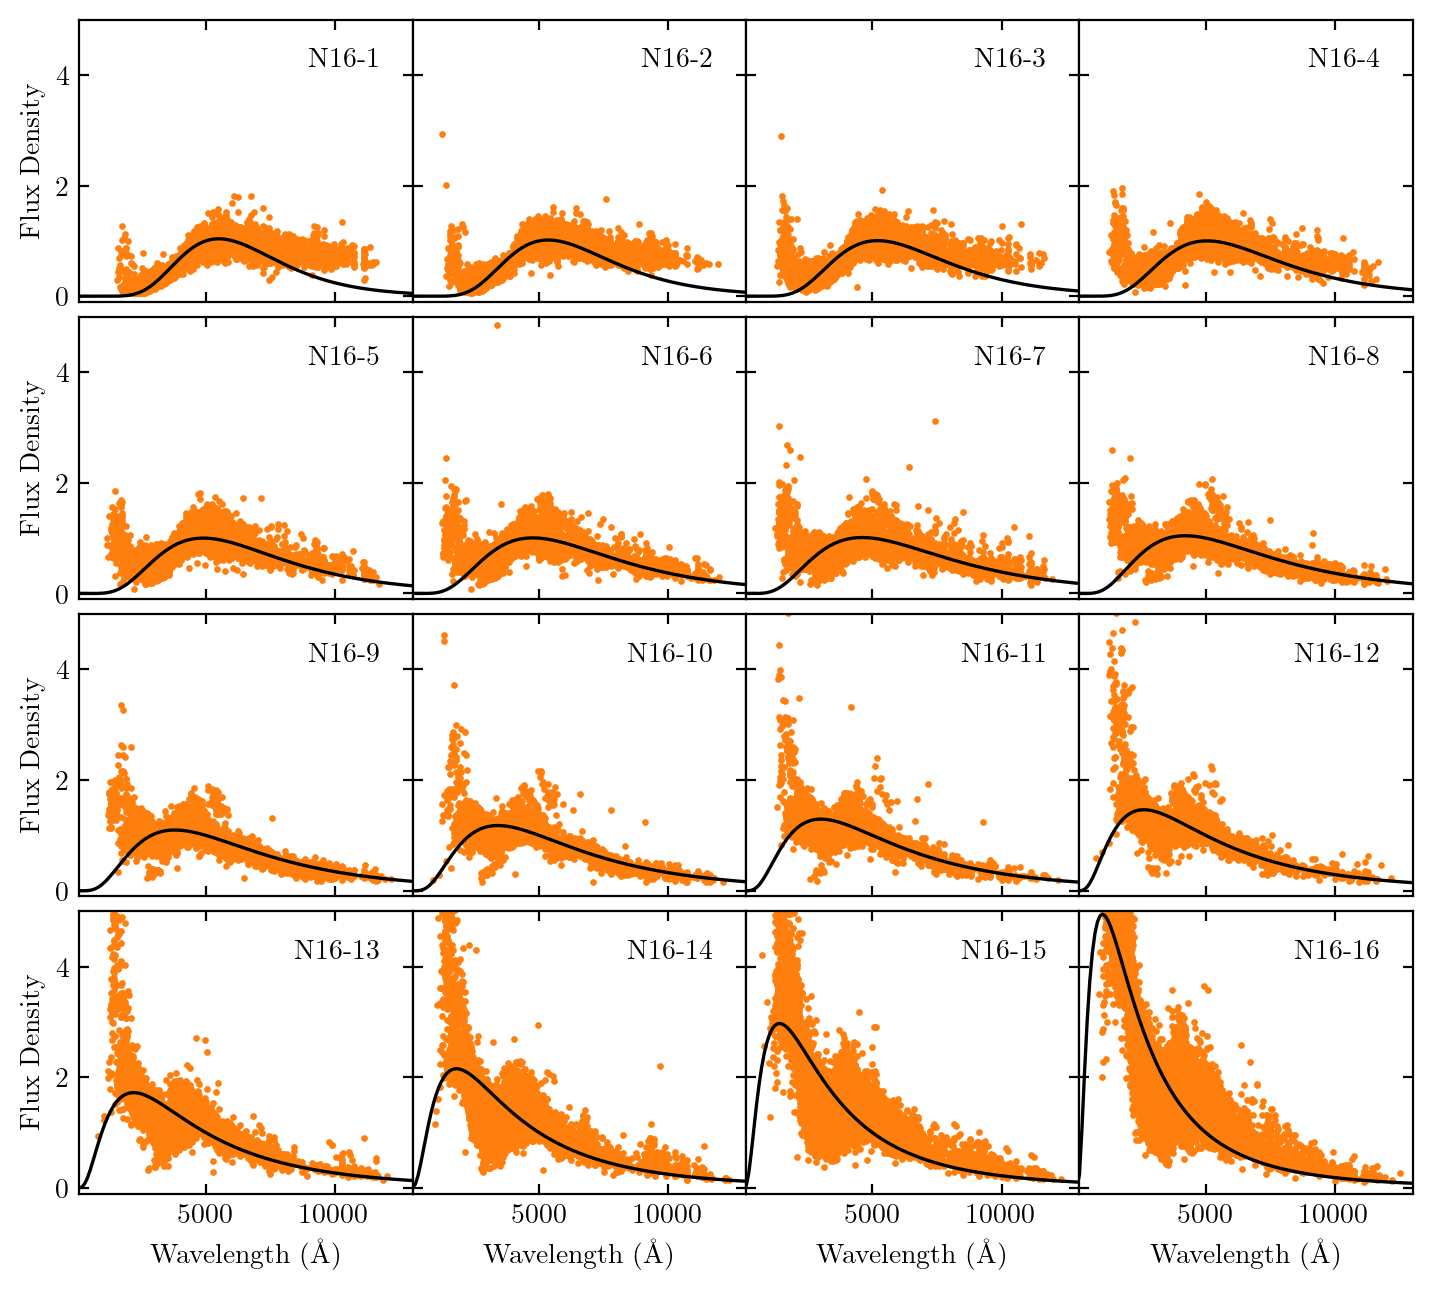

In [9]:
ncols = 4
nrows = int(N/ncols+0.5)
fig, axes = plt.subplots(nrows,ncols,sharex='all',sharey='row',figsize=(twocol,twocol*nrows/ncols*0.9))

print("Number of fluxes in each training set:")
print([len(i) for i in training_sets.values()])

for i,ax in enumerate(axes.flatten()):
    
    wavelen = [row[0] for row in training_sets["N16_"+str(i+1)]]
    fluxes  = [row[1] for row in training_sets["N16_"+str(i+1)]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    template = naive_templates["N16_"+str(i+1)]
    ax.plot(template.wavelen, template.flambda, ls="-", c="k")
    
    ax.text(0.9,0.9,"N16-"+str(i+1),transform=ax.transAxes,ha="right",va="top")
    
    ax.set_xlim(100,13000)
    ax.set_ylim(-0.1,5)

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    
fig.tight_layout(pad=0.5, h_pad=0.15, w_pad=0)
plt.show()

#fig.savefig('plots/N16_untrained.png')

Now train the templates

In [13]:
%%time
trained_templates, final_sets, history = train_templates(naive_templates, galaxies, bandpass_dict, w=0.5, dmse_stop=0.05, verbose=True)

Round 1
N16_1:   69.0   39.6   33.1   30.6   29.4  
N16_2:   88.7   52.5   47.2   45.7  
N16_3:   95.5   66.4   62.1   60.3  
N16_4:   94.1   70.5   67.4  
N16_5:   75.5   56.7   54.3  
N16_6:   72.9   54.7   52.2  
N16_7:   87.8   66.3   62.8   61.1  
N16_8:   55.1   35.4   33.2   32.1  
N16_9:   56.8   32.9   31.4  
N16_10:   87.4   51.9   50.2  
N16_11:  123.9   76.6   73.3  
N16_12:  212.8  135.8  130.0  
N16_13:  271.8  153.8  144.2  140.1  
N16_14:  597.2  364.3  341.7  332.6  
N16_15:  931.8  539.3  516.6  
N16_16: 1548.0  932.4  910.5  
Round 2
N16_1:   32.6   28.3   27.4  
N16_2:   40.5   35.4   34.7  
N16_3:   50.4   44.0   43.3  
N16_4:   44.8   39.5   39.1  
N16_5:   38.4   34.5   33.9  
N16_6:   27.7   25.7   25.4  
N16_7:   31.7   28.8   27.8  
N16_8:   22.3   20.6   20.1  
N16_9:   25.5   24.2   24.0  
N16_10:   16.9   15.7   15.6  
N16_11:   41.9   39.3   38.9  
N16_12:   71.5   63.4   62.9  
N16_13:  104.9   79.3   77.2  
N16_14:  196.2  173.8  170.9  
N16_15:  259.5  

Save the results!

In [16]:
"""for template in trained_templates:
    file = open('templates/'+template+'.sed','w')
    x = copy.copy(trained_templates[template].wavelen)
    y = copy.copy(trained_templates[template].flambda)
    # upsample to every 10 angstroms
    xnew = np.arange(x[0],x[-1],10)
    ynew = np.interp(xnew,x,y)
    for i in range(len(xnew)):
        file.write("{0:<10.2f}{1:<10.4f}\n".format(xnew[i],ynew[i]))
    file.close()
    
f = open("templates/N16_training_history.pkl","wb")
pickle.dump(history,f)
f.close()""";

Plot the trained templates

In [17]:
"""# Load the trained templates from files if you didn't run the training algorithm
trained_templates = dict()
for template in naive_templates:
    x,y = np.loadtxt('templates/'+template+'.sed',unpack=True)
    trained_templates[template] = Sed(x,y)
    
final_sets = create_training_sets(trained_templates, galaxies, bandpass_dict)""";

Number of fluxes in each training set:
[26739, 22206, 22153, 25887, 29516, 26978, 21906, 28893, 23518, 31534, 33277, 31164, 19061, 32616, 24654, 11626]


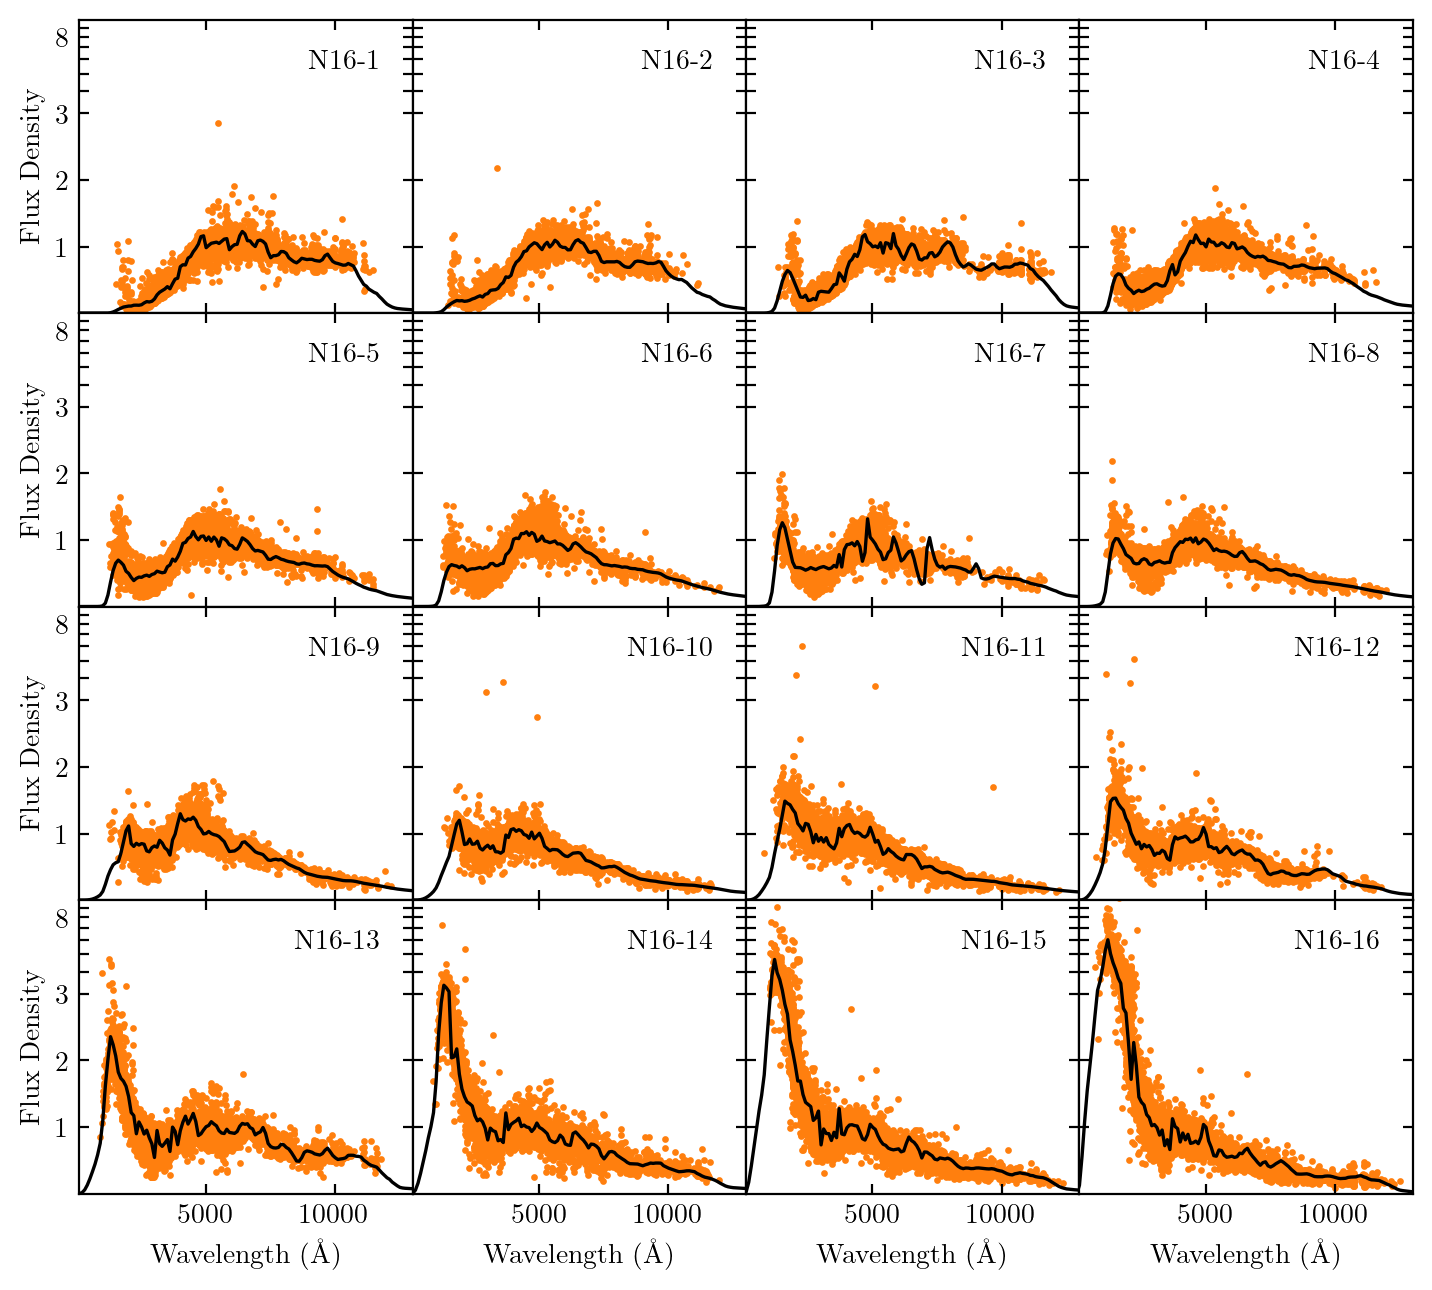

In [23]:
ncols = 4
nrows = int(N/ncols+0.5)
fig, axes = plt.subplots(nrows,ncols,sharex='all',sharey='row',figsize=(twocol,twocol*nrows/ncols*0.9))

print("Number of fluxes in each training set:")
print([len(i) for i in final_sets.values()])

for i,ax in enumerate(axes.flatten()):
    
    wavelen = [row[0] for row in final_sets["N16_"+str(i+1)]]
    fluxes  = [row[1] for row in final_sets["N16_"+str(i+1)]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    template = trained_templates["N16_"+str(i+1)]
    ax.plot(template.wavelen, template.flambda, ls="-", c="k")
    
    ax.text(0.9,0.9,"N16-"+str(i+1),transform=ax.transAxes,ha="right",va="top")
    
    ax.set_xlim(100,13000)
    ax.set_ylim(-0.1,5)

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
    ax.set_xlim(100,13000)
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    ax.set_yscale('symlog',linthreshy=3)
    ax.set_ylim(0,10)
    ax.set_yticks([1,2,3,4,5,6,7,8,9])
    ax.set_yticklabels([1,2,3,'','','','',8,''])
    
fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/N16_trained.png')